<a href="https://colab.research.google.com/github/kaisei3506/close_price_prediction/blob/main/past60days_future1day_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [76]:
!pip install japanize_matplotlib
import japanize_matplotlib

In [77]:
# 再現性確保

import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [78]:
df = pd.read_csv('/content/drive/MyDrive/assignment-main(new)/Trainee/time-series-prediction/my_cleaned_stock_price.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,close,open,high,low,volume,return
date,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,0.1625
1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-0.0543
1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,0.0174
1987-02-17,182.4,176.5,184.3,175.5,8.815100e+08,0.0393
1987-02-18,191.2,186.3,191.2,186.3,7.950900e+08,0.0482
...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,1.550800e+08,-0.0013
2024-07-29,159.7,158.7,160.2,158.4,1.262800e+08,0.0114
2024-07-30,158.7,158.8,159.2,158.0,1.381400e+08,-0.0063


In [79]:
import holidays

def compute_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(span=window, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(span=window, adjust=False).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def engineer(df_old):

  df_new = df_old.copy()

  df_new['sin_dayofyear'] = np.sin(2 * np.pi * df_new.index.dayofyear / 365)
  df_new['cos_dayofyear'] = np.cos(2 * np.pi * df_new.index.dayofyear / 365)
  df_new['sin_dayofmonth'] = np.sin(2 * np.pi * df_new.index.day / 30)
  df_new['cos_dayofmonth'] = np.cos(2 * np.pi * df_new.index.day / 30)
  '''
  df_new['sin_dayofweek'] = np.sin(2 * np.pi * df_new.index.dayofweek / 7)
  df_new['cos_dayofweek'] = np.cos(2 * np.pi * df_new.index.dayofweek / 7)

  # 日本の休日
  jp_holidays = holidays.Japan()
  df_new['holiday'] = df_new.index.map(lambda x: 1 if x in jp_holidays else 0)
  '''

  # 移動平均、相対力指数
  sma_list = [5, 10, 20, 60]
  for i in sma_list:
    df_new[f'sma_{i}'] = df_new['close'].rolling(window=i).mean()
    df_new[f'ema_{i}'] = df_new['close'].ewm(span=i, adjust=False).mean()
    df_new[f'rsi_{i}'] = compute_rsi(df_new, window=i)

  # 標準偏差
  for i in sma_list:
    df_new[f'std_{i}'] = df_new['close'].rolling(window=i).std()

  # 急激な上昇をとらえる
  for i in range(len(sma_list)):
    for j in range(i+1, len(sma_list)):

      df_new[f'sma_{sma_list[i]}vs{sma_list[j]}'] = df_new[f'sma_{sma_list[i]}'] / df_new[f'sma_{sma_list[j]}']

      # ゴールデンクロス
      df_new[f'gc_{sma_list[i]}vs{sma_list[j]}'] = (df_new[f'sma_{sma_list[i]}'].shift(1) < df_new[f'sma_{sma_list[j]}'].shift(1)) & (df_new[f'sma_{sma_list[i]}'] >= df_new[f'sma_{sma_list[j]}'])
      # デッドクロス
      df_new[f'dc_{sma_list[i]}vs{sma_list[j]}'] = (df_new[f'sma_{sma_list[i]}'].shift(1) > df_new[f'sma_{sma_list[j]}'].shift(1)) & (df_new[f'sma_{sma_list[i]}'] <= df_new[f'sma_{sma_list[j]}'])

      # MACD
      df_new[f'macd_{sma_list[i]}vs{sma_list[j]}'] = df_new[f'ema_{sma_list[i]}'] - df_new[f'ema_{sma_list[j]}']
      df_new[f'macd_signal_{sma_list[i]}vs{sma_list[j]}'] = df_new[f'macd_{sma_list[i]}vs{sma_list[j]}'].ewm(span=9, adjust=False).mean()
  '''
  # ADX
  epsilon = 1e-6
  df_new['+DM'] = df_new['high'] - df_new['high'].shift(1)
  df_new['-DM'] = df_new['low'].shift(1) - df_new['low']
  df_new['TR'] = np.maximum.reduce([
    df_new['high'] - df_new['low'],
    abs(df_new['high'] - df_new['close'].shift(1)),
    abs(df_new['low'] - df_new['close'].shift(1))
    ])
  df_new['+DI'] = df_new['+DM'].rolling(window=14).sum() / (df_new['TR'].rolling(window=14).sum() + epsilon) * 100
  df_new['-DI'] = df_new['-DM'].rolling(window=14).sum() / (df_new['TR'].rolling(window=14).sum() + epsilon) * 100
  df_new['DX'] = abs((df_new['+DI'] - df_new['-DI']) / (df_new['+DI'] + df_new['-DI'] + epsilon)) * 100
  df_new['ADX'] = df_new['DX'].rolling(window=14).mean()

  # ストキャスティクス
  df_new['%K'] = (df_new['close'] - df_new['low'].rolling(window=14).min()) / (df_new['high'].rolling(window=14).max() - df_new['low'].rolling(window=14).min()) * 100
  df_new['%D'] = df_new['%K'].rolling(window=3).mean()
  '''


  #df_new = df_new.drop(['open', 'high', 'low'], axis=1)

  df_new = df_new.dropna()


  return df_new

engineered_df = engineer(df)
engineered_df

,close,open,high,low,volume,return,sin_dayofyear,cos_dayofyear,sin_dayofmonth,cos_dayofmonth,...,sma_10vs60,gc_10vs60,dc_10vs60,macd_10vs60,macd_signal_10vs60,sma_20vs60,gc_20vs60,dc_20vs60,macd_20vs60,macd_signal_20vs60
date,,,,,,,,,,,,,,,,,,,,,
1987-05-11,305.9,305.9,308.8,303.9,126670000.0,0.0033,0.774884,-0.632103,7.431448e-01,-0.669131,...,1.117822,False,False,32.674630,31.598004,1.083202,False,False,25.569919,25.077229
1987-05-12,297.1,302.9,302.9,297.1,124020000.0,-0.0288,0.763889,-0.645348,5.877853e-01,-0.809017,...,1.107688,False,False,31.480009,31.574405,1.080607,False,False,25.123581,25.086500
1987-05-13,292.2,295.1,297.1,289.2,114610000.0,-0.0165,0.752667,-0.658402,4.067366e-01,-0.913545,...,1.096988,False,False,29.616725,31.182869,1.077901,False,False,24.348531,24.938906
1987-05-14,290.2,292.2,295.1,290.2,65130000.0,-0.0068,0.741222,-0.671260,2.079117e-01,-0.978148,...,1.089646,False,False,27.667588,30.479813,1.075381,False,False,23.469355,24.644996
1987-05-15,288.2,292.2,293.1,287.3,64250000.0,-0.0069,0.729558,-0.683919,5.665539e-16,-1.000000,...,1.084052,False,False,25.662131,29.516277,1.071486,False,False,22.501803,24.216357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,155080000.0,-0.0013,-0.425000,-0.905193,-7.431448e-01,0.669131,...,1.024136,False,False,0.198494,-0.403563,1.015862,False,False,-1.000526,-1.887455
2024-07-29,159.7,158.7,160.2,158.4,126280000.0,0.0114,-0.471160,-0.882048,-2.079117e-01,0.978148,...,1.025969,False,False,0.368923,-0.249066,1.019587,False,False,-0.818697,-1.673703
2024-07-30,158.7,158.8,159.2,158.0,138140000.0,-0.0063,-0.486273,-0.873807,-1.133108e-15,1.000000,...,1.028228,False,False,0.352562,-0.128741,1.021677,False,False,-0.719473,-1.482857


In [80]:
train_valid = engineered_df['2019-01-01':'2023-12-31']

train = train_valid[:'2022-11-30']
enbargo_train_valid = train_valid['2022-12-01':'2022-12-31']
valid = train_valid['2023-01-01':'2023-07-31']
enbargo_valid_test = engineered_df['2023-08-01':'2024-12-31']
test = engineered_df['2024-01-01':'2024-07-31']

In [81]:
sequence_length = 22
predict_length = 1

def create_dataset(data, sequence_length, predict_length):
  X, y = [], []
  for i in range(len(data) - sequence_length - predict_length + 1):
    X.append(data[i:i+sequence_length, :])
    y.append(data[i+sequence_length:i+sequence_length+predict_length, 0])
  return np.array(X), np.array(y)

X_train, y_train = create_dataset(train.values, sequence_length, predict_length)
X_valid, y_valid = create_dataset(valid.values, sequence_length, predict_length)
X_test, y_test = create_dataset(test.values, sequence_length, predict_length)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_valid = y_valid.reshape(y_valid.shape[0], y_valid.shape[1], 1)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(928, 22, 56)
(928, 1, 1)
(120, 22, 56)
(120, 1, 1)


In [82]:
from sklearn.preprocessing import StandardScaler

# 特徴量（X）のスケーリング
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid_scaled = scaler_X.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 目的変数（y）のスケーリング
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, y_valid.shape[-1])).reshape(y_valid.shape)

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers as optim
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

In [84]:
# LSTM

lstm_model = Sequential()

lstm_model.add(LSTM(units=128,
                    return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=64,
                    return_sequences=False,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(predict_length,
                     kernel_regularizer=regularizers.l2(0.001)
                     )
)


optimizer = optim.Adam(learning_rate=0.0005)
lstm_model.compile(optimizer=optimizer, loss='mse')
plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
lstm_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 22, 128)        │        94,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,193 (563.25 KB)

 Trainable params: 144,193 (563.25 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)
lstm_model.fit(X_train_scaled, y_train_scaled,
               epochs=1000,
               batch_size=64,
               validation_data=(X_valid_scaled, y_valid_scaled),
               shuffle=False,
               callbacks=[es])

# 検証データの損失が最も小さかったエポックを取得
best_epoch = np.argmin(lstm_model.history.history['val_loss']) + 1
print(f"検証データの損失が最も小さかったエポック: {best_epoch}")
# そのエポックの学習損失と検証損失を取得
best_train_loss = lstm_model.history.history['loss'][best_epoch - 1]
best_val_loss = lstm_model.history.history['val_loss'][best_epoch - 1]
print(f"エポック {best_epoch}での学習損失: {best_train_loss}")
print(f"エポック {best_epoch}での検証損失: {best_val_loss}")

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - loss: 0.8795 - val_loss: 0.6795
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.8136 - val_loss: 0.4690
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.5613 - val_loss: 0.7103
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.5078 - val_loss: 0.4546
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.4618 - val_loss: 0.5860
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.4454 - val_loss: 0.4436
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.4361 - val_loss: 0.4489
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.4238 - val_loss: 0.4480
Epoch 9/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.4146 - val_loss: 0.4181
Epoch 10/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.4042 - val_loss: 0.4109
Epoch 11/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.3927 - val_loss: 0.3943
Epoch 12/1000
15/15 ━━━━━━━━━━━━━━

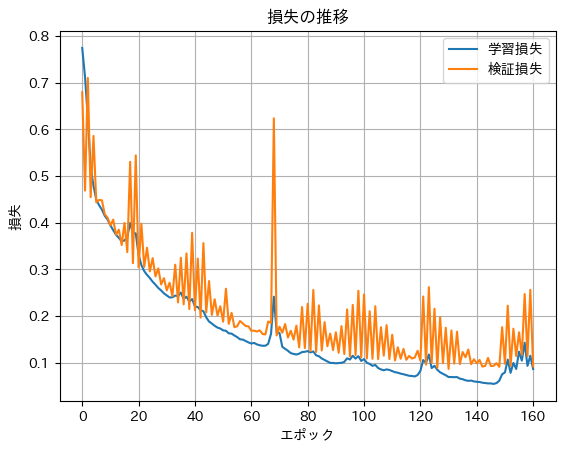

In [86]:
# 損失関数の推移
plt.plot(lstm_model.history.history['loss'], label='学習損失')
plt.plot(lstm_model.history.history['val_loss'], label='検証損失')
plt.title('損失の推移')
plt.xlabel('エポック')
plt.ylabel('損失')
plt.legend()
plt.grid()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━

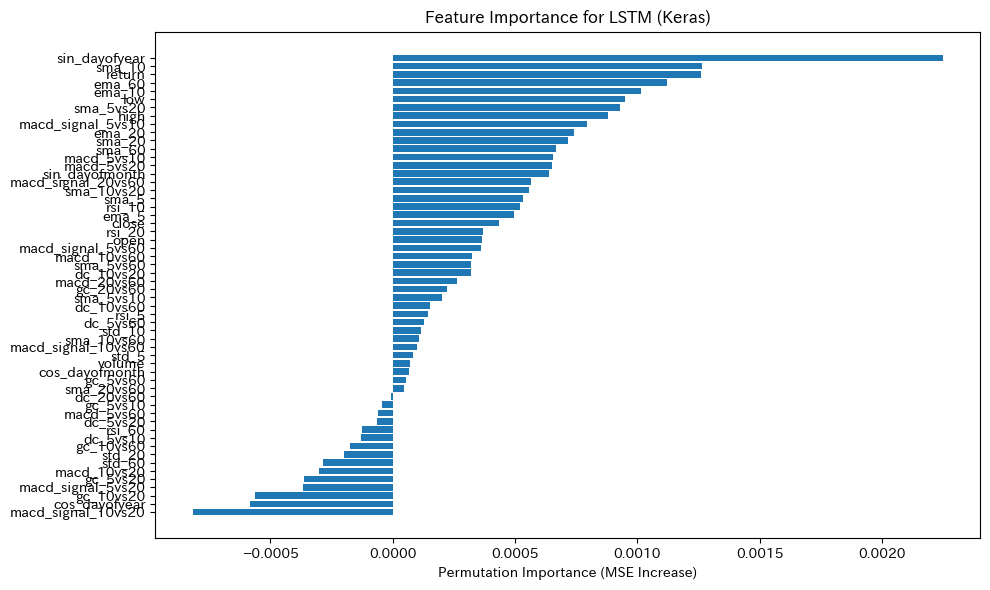

               Feature  Importance
6        sin_dayofyear    0.002246
13              sma_10    0.001262
5               return    0.001260
20              ema_60    0.001123
14              ema_10    0.001014
3                  low    0.000951
31           sma_5vs20    0.000927
2                 high    0.000879
30   macd_signal_5vs10    0.000794
17              ema_20    0.000739
16              sma_20    0.000717
19              sma_60    0.000668
29          macd_5vs10    0.000655
34          macd_5vs20    0.000652
8       sin_dayofmonth    0.000638
55  macd_signal_20vs60    0.000564
41          sma_10vs20    0.000556
10               sma_5    0.000531
15              rsi_10    0.000521
11               ema_5    0.000494
0                close    0.000434
18              rsi_20    0.000368
1                 open    0.000363
40   macd_signal_5vs60    0.000359
49         macd_10vs60    0.000325
36           sma_5vs60    0.000321
43           dc_10vs20    0.000320
54         macd_20vs

In [87]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 検証データ（X_valid_scaled）は (samples, timesteps, features) の形
X_valid_copy = X_valid_scaled.copy()
baseline_preds = lstm_model.predict(X_valid_scaled).ravel()
baseline_score = mean_squared_error(y_valid_scaled.ravel(), baseline_preds)

# 特徴量数
n_features = X_valid_scaled.shape[2]
feature_names = engineered_df.columns

# 順列重要度を格納
importances = []

# 各特徴量について
for i in range(n_features):
    # コピーを作成
    X_permuted = X_valid_copy.copy()

    # 各time stepでその特徴をシャッフル
    for t in range(X_valid_scaled.shape[1]):  # timesteps
        np.random.seed(42)
        np.random.shuffle(X_permuted[:, t, i])

    # 予測してスコア計算
    permuted_preds = lstm_model.predict(X_permuted).ravel()
    permuted_score = mean_squared_error(y_valid_scaled.ravel(), permuted_preds)

    # スコアの悪化分を重要度とする
    importance = permuted_score - baseline_score
    importances.append(importance)

# 結果をDataFrameにまとめて可視化
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance (MSE Increase)')
plt.title('Feature Importance for LSTM (Keras)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 表としても表示
print(importance_df)


In [88]:
'''
# 再学習

train_new = train_valid[:'2023-11-30']

X_train_new, y_train_new = create_dataset(train_new.values, sequence_length, predict_length)

scaler_X_new = StandardScaler()
X_train_new_scaled = scaler_X_new.fit_transform(X_train_new.reshape(-1, X_train_new.shape[-1])).reshape(X_train_new.shape)

scaler_y_new = StandardScaler()
y_train_new_scaled = scaler_y_new.fit_transform(y_train_new.reshape(-1, y_train_new.shape[-1])).reshape(y_train_new.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lstm_model.fit(X_train_new_scaled, y_train_new_scaled,
               epochs=1000,
               batch_size=64,
               validation_data=(X_valid_scaled, y_valid_scaled),
               shuffle=False,
               callbacks=[es])

'''

"\n# 再学習\n\ntrain_new = train_valid[:'2023-11-30']\n\nX_train_new, y_train_new = create_dataset(train_new.values, sequence_length, predict_length)\n\nscaler_X_new = StandardScaler()\nX_train_new_scaled = scaler_X_new.fit_transform(X_train_new.reshape(-1, X_train_new.shape[-1])).reshape(X_train_new.shape)\n\nscaler_y_new = StandardScaler()\ny_train_new_scaled = scaler_y_new.fit_transform(y_train_new.reshape(-1, y_train_new.shape[-1])).reshape(y_train_new.shape)\n\nes = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)\nlstm_model.fit(X_train_new_scaled, y_train_new_scaled,\n               epochs=1000,\n               batch_size=64,\n               validation_data=(X_valid_scaled, y_valid_scaled),\n               shuffle=False,\n               callbacks=[es])\n\n"

In [89]:
'''
from sklearn.metrics import mean_squared_error

y_test_pred_scaled = lstm_model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_pred = y_test_pred.flatten()
y_test = y_test.flatten()

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Test RMSE: {test_rmse}")
'''

'\nfrom sklearn.metrics import mean_squared_error\n\ny_test_pred_scaled = lstm_model.predict(X_test_scaled)\ny_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)\ny_test_pred = y_test_pred.flatten()\ny_test = y_test.flatten()\n\ntest_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))\n\nprint(f"Test RMSE: {test_rmse}")\n'

In [90]:
'''
plt.figure(figsize=(12,8))
plt.plot(test[sequence_length:].index, y_test, label='実測値')
plt.plot(test[sequence_length:].index, y_test_pred, label='予測値')
plt.title('終値の予測', fontsize=25)
plt.xlabel('日付', fontsize=20)
plt.ylabel('価格(円)', fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()
'''

"\nplt.figure(figsize=(12,8))\nplt.plot(test[sequence_length:].index, y_test, label='実測値')\nplt.plot(test[sequence_length:].index, y_test_pred, label='予測値')\nplt.title('終値の予測', fontsize=25)\nplt.xlabel('日付', fontsize=20)\nplt.ylabel('価格(円)', fontsize=20)\nplt.legend(fontsize=20)\nplt.grid()\nplt.show()\n"

In [91]:
'''
plt.figure(figsize=(16,8))
plt.plot(test.index, test['close'].values, label='Actual')
plt.plot(test[sequence_length:].index, y_test_pred, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
'''

"\nplt.figure(figsize=(16,8))\nplt.plot(test.index, test['close'].values, label='Actual')\nplt.plot(test[sequence_length:].index, y_test_pred, label='Predicted')\nplt.title('Stock Price Prediction')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.legend()\nplt.grid()\nplt.show()\n"